 This notebook was part of TestUVfromColdStart, just plot to see the RMS between original nowcast and that from cold start, with other conditions all the same. 

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime 
import os
from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools
from salishsea_tools.nowcast import analyze
from IPython.core.display import Image
from __future__ import division, print_function
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 77,##426 start from 349 fortran start from 350
        'j' : 34,##293 start from 259 fortran start from 260
    },
    'VENUS East':{
        'lat' : 49.0419,
        'lon' : -123.3176,
        'depth' : 170,
        'i' : 67,
        'j' : 24
    },    
    'VENUS Central': {
        'lat': 49.0401,
        'lon': -123.4261,
        'depth' : 300,
        'i': 75,
        'j': 7
        },

    'VENUS Delta': {
        'lat': 49.0807167,
        'lon': -123.3400617,
        'i':  76,
        'j':25
    },
    'S4-3':{
        'lat': 49.25 ,
        'lon':  -123.375,
        'i':112,
        'j': 41
        },
    }
# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '20', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '18'}

In [11]:
grid_U = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast_allthesame/1hnowcastallthesame06160629gridU.nc')
u = grid_U.variables['vozocrtx']
print (u[:, 0 ,77:79, 34:38].shape)
uu= np.nanmean(u[:, 0 ,77:79, 34:38],axis = 2)
uuu = np.nanmean(uu,axis = 1)
print (uu.shape)
print(uuu.shape)
u_mine = np.nanmean(np.nanmean(u[:, 0 ,77:79, 34:38],axis = 2), axis = 1)
for i,j in zip(uuu, u_mine):
    if i-j!=0:
        print(i,j)

(336, 2, 4)
(336, 2)
(336,)


In [3]:
directory='15days_nowcast_allthesame'
base='/data/jieliu/MEOPAR/river-treatment/'
base_original = '/data/dlatorne/MEOPAR/SalishSea/nowcast/';
ufile_pattern = '{}/1hnowcastallthesame06150629gridU.nc'
vfile_pattern = '{}/1hnowcastallthesame06150629gridV.nc'
Us={};Vs={}; 
##load my nowcasts
path = os.path.join(base,ufile_pattern.format(directory))
f = nc.Dataset(path,'r');
Us[base] = f.variables['vozocrtx'][:]
path = os.path.join(base,vfile_pattern.format(directory))
f = nc.Dataset(path,'r');
Vs[base] = f.variables['vomecrty'][:]

In [4]:
##load original nowcasts from june 15-29
to = datetime.datetime(2015,6,15)
tf = datetime.datetime(2015,6,29)
j_list = []; i_list = []
for j in np.arange(898):
    j_list.append(j)
for i in np.arange(398):
    i_list.append(i)
#daily averages of original nowcasts
files_U = analyze.get_filenames(to,tf,'1h','grid_U',base_original)
u_daily, time_daily = analyze.combine_files(files_U, 'vozocrtx',0,j_list,i_list)
files_V = analyze.get_filenames(to,tf,'1h','grid_V',base_original)
v_daily, time_daily = analyze.combine_files(files_V, 'vomecrty',0,j_list, i_list)

In [ ]:
directory=['14days_nowcast_allthesame','15jun15']
bases=['/data/jieliu/MEOPAR/river-treatment/',\
      '/data/jieliu/MEOPAR/river-treatment/24hrs_nowcast_allthesame/15jun15/']
base_original = '/data/dlatorne/MEOPAR/SalishSea/nowcast/';
ufile_pattern = ['{}/1hnowcastallthesame06160629gridU.nc','{}/SalishSea_1h_20150615_20150615_grid_U.nc']
vfile_pattern = ['{}/1hnowcastallthesame06160629gridV.nc', '{}/SalishSea_1h_20150615_20150615_grid_V.nc']
Us16={};Vs16={}; 
##load my nowcasts
for base, u_pattern, v_pattern in zip(bases, ufile_pattern, vfile_pattern): 
    path = os.path.join(base,u_pattern.format(directory[0]))
    f = nc.Dataset(path,'r');
    Us16[base] = f.variables['vozocrtx'][:]
    path = os.path.join(base,v_pattern.format(directory[0]))
    f = nc.Dataset(path,'r');
    Vs16[base] = f.variables['vomecrty'][:]

##load original nowcasts from june 16-29
to16 = datetime.datetime(2015,6,16)
tf = datetime.datetime(2015,6,29)
j_list = []; i_list = []
for j in np.arange(898):
    j_list.append(j)
for i in np.arange(398):
    i_list.append(i)
#daily averages of original nowcasts
files_U = analyze.get_filenames(to16,tf,'1h','grid_U',base_original)
u_daily16, time_daily = analyze.combine_files(files_U, 'vozocrtx',0,j_list,i_list)
files_V = analyze.get_filenames(to,tf,'1h','grid_V',base_original)
v_daily16, time_daily = analyze.combine_files(files_V, 'vomecrty',0,j_list, i_list)
##load separate original nowcast for june 15
path = os.path.join(base_original, ufile_pattern[1].format(directory[1]))
f = nc.Dataset(path,'r');
u_15daily = f.variables['vozocrtx'][:]
path = os.path.join(base_original, vfile_pattern[1].format(directory[1]))
f=nc.Dataset(path,'r');
v_15daily = f.variables['vomecrty'][:]

In [6]:
def rms(station,  continue_flag = True,point_flag = True):
    """Plot rms for point station or for spatial averaged based on 
       point_flag"""

    if (continue_flag) & (point_flag):
        filess = analyze.get_filenames(to,tf,'1d','grid_T',base_original)
        none, time_dailyuse = analyze.combine_files(filess, 'vosaline',0,\
                        sites[station]['i']+349,sites[station]['j'] + 259)
        add_relative=np.zeros(time_dailyuse.shape)
        rms_relative=np.zeros(time_dailyuse.shape)
        z= 0

        ##for june 15 to 29
        for i in np.arange(0, 360, 24):
            for j in np.arange(24):
                jj= i+j
                add_relative[z] = add_relative[z] +\
                (Us[base][jj, 0,sites[station]['i'], sites[station]['j']]-u_daily[jj, sites[station]['i']+349,\
                                                    sites[station]['j']+259])**2\
                +(Vs[base][jj, 0,sites[station]['i'], sites[station]['j']]-v_daily[jj, sites[station]['i']+349,\
                                                    sites[station]['j']+259])**2
            z = z+1
        rms_relative[:] = np.sqrt(add_relative[:]/24) 
        
    elif point_flag: 
        #print ('spatial averaged or not start from June 15')
    ## for june 16 to 29
            ##create new time arange for the whole time period from june 15-29
        too = to.replace(day = 15)
        filess = analyze.get_filenames(too,tf,'1d','grid_T',base_original)
        none, time_dailyuse = analyze.combine_files(filess, 'vosaline',0,\
                        sites[station]['i']+349,sites[station]['j'] + 259)
        add_relative=np.zeros(time_dailyuse.shape)
        rms_relative=np.zeros(time_dailyuse.shape)
        z= 1
        for i in np.arange(0, 336, 24):
            for j in np.arange(24):
                jj= i+j
                add_relative[z] = add_relative[z] +\
                (Us[bases[0]][jj, 0,sites[station]['i'], sites[station]['j']]-u_daily[jj, sites[station]['i']+349,\
                                                    sites[station]['j']+259])**2\
                +(Vs[bases[0]][jj, 0,sites[station]['i'], sites[station]['j']]-v_daily[jj, sites[station]['i']+349,\
                                                    sites[station]['j']+259])**2
            z = z+1
            
        ## added up june 15 
        for k in np.arange(24):
            add_relative[0] = add_relative[0]+(Us[bases[1]][k, 0,sites[station]['i'], sites[station]['j']]\
                                    - u_15daily[k,0, sites[station]['i']+349, sites[station]['j']+259])**2 +\
            (Vs[bases[1]][k,0,sites[station]['i'], sites[station]['j']]\
                                    - v_15daily[k,0,sites[station]['i']+349, sites[station]['j']+259])**2
        rms_relative[:] = np.sqrt(add_relative[:]/24) 
        
    ## plot
    fig, axs = plt.subplots(1, 1, figsize=(12, 4))    
    
    axs.plot(time_dailyuse, rms_relative, linewidth = 2, marker ='.', color ='indigo')
    axs.grid('on')
    axs.set_ylim([0,0.6])
    axs.set_ylabel('RMS', **axis_font)
    
    return fig, rms_relative        

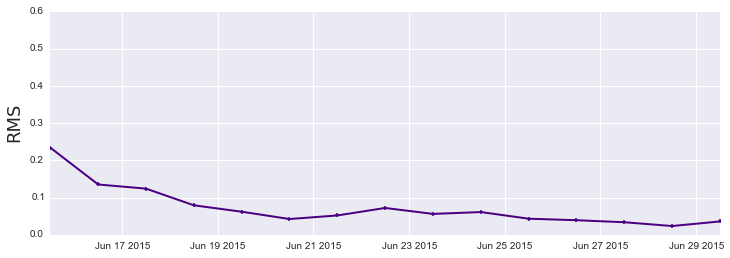

In [7]:
fig,rms_relative = rms( 'Sandheads', continue_flag = True,point_flag = True)
#fig,rms_relative = rms( 'Sandheads', continue_flag = False,point_flag = True)

array([ 0.22433761,  0.14130146,  0.10296259,  0.15892953,  0.14554937,
        0.09265576,  0.05923415,  0.06515524,  0.07416296,  0.11006923,
        0.14828462,  0.10155184,  0.04307402,  0.06386943,  0.0862498 ])

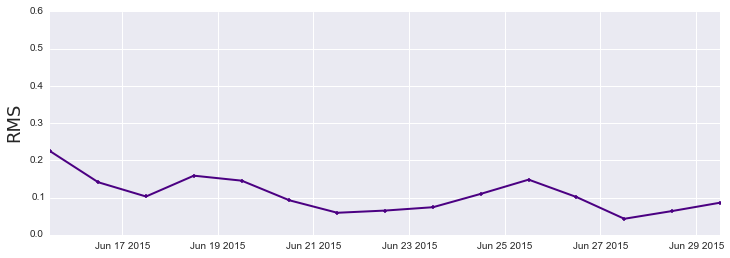

In [8]:
fig,rms_relative = rms( 'VENUS Central', continue_flag = True,point_flag = True)
rms_relative

array([ 0.27283124,  0.18355948,  0.1463283 ,  0.113261  ,  0.09235564,
        0.05629922,  0.06783109,  0.05713415,  0.06980341,  0.10429772,
        0.07812439,  0.06089437,  0.0535865 ,  0.04197935,  0.10031704])

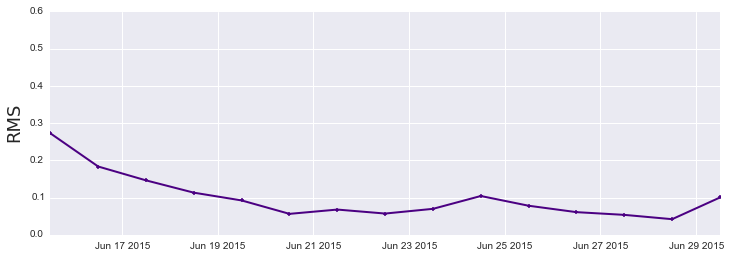

In [9]:
fig,rms_relative = rms( 'VENUS East', continue_flag = True,point_flag = True)
rms_relative

array([ 0.22564028,  0.1920121 ,  0.18337655,  0.11026554,  0.07466886,
        0.06289329,  0.06446307,  0.06121358,  0.05902666,  0.07892164,
        0.05858964,  0.05020799,  0.04332264,  0.03189391,  0.15231559])

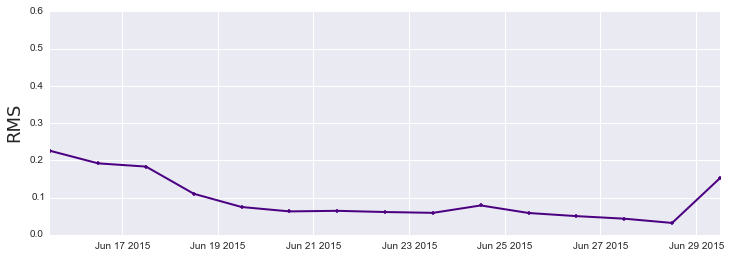

In [10]:
fig,rms_relative = rms( 'VENUS Delta', continue_flag = True,point_flag = True)
rms_relative

array([ 0.17473611,  0.13405181,  0.10344183,  0.06950362,  0.06632743,
        0.07078754,  0.09266342,  0.08183197,  0.03625511,  0.02812569,
        0.01866736,  0.01870536,  0.02142977,  0.02580428,  0.06751027])

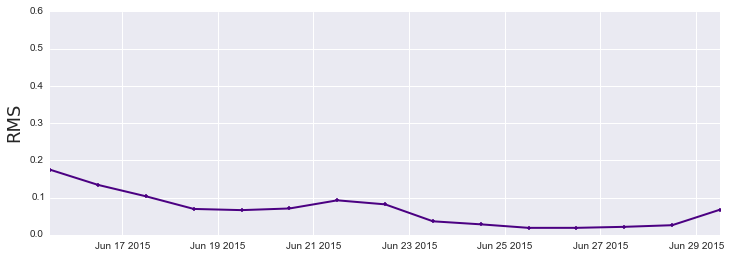

In [11]:
fig,rms_relative = rms( 'S4-3', continue_flag = True,point_flag = True)
rms_relative